In [104]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import shap
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import  tensorflow as tf
from gensim.models import KeyedVectors
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,ConfusionMatrixDisplay,classification_report, roc_auc_score

In [105]:
df = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/edstays3_v3.csv')

In [106]:
# rename columns stay_id_triage to stay_id 
df.rename(columns={'stay_id_triage':'stay_id'}, inplace=True)
df.rename(columns={'subject_id_triage':'subject_id'}, inplace=True)


In [107]:
icd_code_df = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/previous_icd_code.csv') 

In [108]:
vital = pd.read_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/vitalsign.csv')

In [109]:
vital.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646976 entries, 0 to 1646975
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   subject_id   1646976 non-null  int64  
 1   stay_id      1646976 non-null  int64  
 2   charttime    1646976 non-null  object 
 3   temperature  1052781 non-null  float64
 4   heartrate    1573609 non-null  float64
 5   resprate     1552909 non-null  float64
 6   o2sat        1503831 non-null  float64
 7   sbp          1561439 non-null  float64
 8   dbp          1561439 non-null  float64
 9   rhythm       62792 non-null    object 
 10  pain         1180066 non-null  object 
dtypes: float64(6), int64(2), object(3)
memory usage: 138.2+ MB


In [110]:
vi_count = vital.groupby(['subject_id', 'stay_id']).size()

In [111]:
vi_count

subject_id  stay_id 
10000032    32952584     7
            33258284     1
            35968195     2
            38112554     2
            39399961    11
                        ..
19999784    37972930     4
19999828    30712109    11
            32917002     7
19999914    32002659     1
19999987    34731548     3
Length: 429839, dtype: int64

In [112]:
df3 = df.merge(vi_count.to_frame(name = "count_vital"), on=['subject_id', 'stay_id'])

In [113]:
df3.head()


,Unnamed: 0,subject_id,stay_id,gender,race,arrival_transport,disposition,disposition_binary,admitted,difftime,...,chiefcomplaint,temperature_vitals,heartrate_vitals,resprate_vitals,o2sat_vitals,sbp_vitals,dbp_vitals,rhythm,pain_vitals,count_vital
0,0,10000032,33258284,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 04:13:00,...,"Abd pain, Abdominal distention",98.1,83.0,24.0,97.0,90.0,51.0,NaN,0.0,1
1,1,10000032,38112554,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 05:37:00,...,Abdominal distention,98.1,85.0,22.0,98.0,76.0,39.0,NaN,0.0,2
2,2,10000032,35968195,F,WHITE,AMBULANCE,ADMITTED,0,1,30 days 04:46:00,...,"n/v/d, Abd pain",98.1,84.0,22.0,97.0,75.0,39.0,NaN,0.0,2
3,4,10000032,39399961,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 08:06:00,...,"Abdominal distention, Abd pain, LETHAGIC",98.4,86.0,20.0,98.0,65.0,37.0,NaN,0.0,11
4,5,10000084,35203156,M,WHITE,WALK IN,ADMITTED,0,1,0 days 06:44:00,...,"Confusion, Hallucinations",98.1,85.0,16.0,99.0,83.0,45.0,NaN,0.0,3


In [114]:
my_imputer = SimpleImputer(strategy = 'median')
df3_num_attr = ['temperature_vitals', 'heartrate_vitals', 'resprate_vitals', 'o2sat_vitals', 'sbp_vitals', 'dbp_vitals',
            'temperature_triage', 'heartrate_triage', 'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage']
df3[df3_num_attr] = my_imputer.fit_transform(df3[df3_num_attr])

num_attr = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
vital[num_attr] = my_imputer.fit_transform(vital[num_attr])

In [115]:
vital2_dict = {}
run_num = -1
num_attr = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']

for i in range(len(df3)):
  vital2_dict[i] = np.array(vital.loc[(run_num+1):(run_num+df3.loc[i,'count_vital']),num_attr])
  run_num =run_num+df3.loc[i,'count_vital']

In [116]:
vital3_dict = {}
for i in range(len(vital2_dict)):
  if (len(vital2_dict[i]) == 1): vital3_dict[i] = [(np.append(np.append(vital2_dict[i],vital2_dict[i], axis=0),vital2_dict[i], axis=0))]
  elif (len(vital2_dict[i]) == 2): vital3_dict[i] = [(np.append(vital2_dict[i], np.array([vital2_dict[i][1]]),axis=0))]
  else:
    vital3_dict[i] = [(vital2_dict[i][-3:])]

In [117]:
vital2_dict[0]

array([[98.1, 83. , 24. , 97. , 90. , 51. ]])

In [118]:
temp = pd.DataFrame.from_dict(vital3_dict, orient = 'index')
temp.columns = ['vital_sign']
df3 = pd.merge(df3,temp,how = 'left',left_index=True,right_index=True)

In [119]:
temp.vital_sign[0].shape

(3, 6)

In [120]:
# rename columns subject_id_triage to subject_id
# rename columns stay_id_triage to stay_id
df3.rename(columns={'subject_id_triage':'subject_id', 'stay_id_triage':'stay_id'}, inplace=True)

In [121]:
df3.head()

,Unnamed: 0,subject_id,stay_id,gender,race,arrival_transport,disposition,disposition_binary,admitted,difftime,...,temperature_vitals,heartrate_vitals,resprate_vitals,o2sat_vitals,sbp_vitals,dbp_vitals,rhythm,pain_vitals,count_vital,vital_sign
0,0,10000032,33258284,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 04:13:00,...,98.1,83.0,24.0,97.0,90.0,51.0,NaN,0.0,1,"[[98.1, 83.0, 24.0, 97.0, 90.0, 51.0], [98.1, 83.0, 24.0, 97.0, 90.0, 51.0], [98.1, 83.0, 24.0, 97.0, 90.0, 51.0]]"
1,1,10000032,38112554,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 05:37:00,...,98.1,85.0,22.0,98.0,76.0,39.0,NaN,0.0,2,"[[98.1, 85.0, 22.0, 98.0, 76.0, 39.0], [98.1, 84.0, 22.0, 97.0, 75.0, 39.0], [98.1, 84.0, 22.0, 97.0, 75.0, 39.0]]"
2,2,10000032,35968195,F,WHITE,AMBULANCE,ADMITTED,0,1,30 days 04:46:00,...,98.1,84.0,22.0,97.0,75.0,39.0,NaN,0.0,2,"[[98.1, 84.0, 20.0, 99.0, 86.0, 51.0], [98.4, 86.0, 20.0, 98.0, 65.0, 37.0], [98.4, 86.0, 20.0, 98.0, 65.0, 37.0]]"
3,4,10000032,39399961,F,WHITE,AMBULANCE,ADMITTED,0,1,0 days 08:06:00,...,98.4,86.0,20.0,98.0,65.0,37.0,NaN,0.0,11,"[[98.1, 78.0, 18.0, 95.0, 88.0, 57.0], [98.1, 78.0, 18.0, 94.0, 82.0, 55.0], [98.1, 94.0, 16.0, 95.0, 73.0, 51.0]]"
4,5,10000084,35203156,M,WHITE,WALK IN,ADMITTED,0,1,0 days 06:44:00,...,98.1,85.0,16.0,99.0,83.0,45.0,NaN,0.0,3,"[[98.1, 86.0, 18.0, 94.0, 93.0, 54.0], [98.1, 81.0, 18.0, 92.0, 82.0, 54.0], [98.1, 83.0, 16.0, 92.0, 76.0, 48.0]]"


In [122]:
df3.vital_sign[0].shape

(3, 6)

In [123]:
# Data Merging for NLP
df3 = pd.merge(df3, icd_code_df[['subject_id', 'stay_id','pre_icd_code']], how = "left" ,on=['subject_id', 'stay_id'])

In [124]:
df3.columns

Index(['Unnamed: 0', 'subject_id', 'stay_id', 'gender', 'race',
       'arrival_transport', 'disposition', 'disposition_binary', 'admitted',
       'difftime', 'nights', 'hours', 'admission_hour', 'admission_day',
       'admission_day_of_week', 'temperature_triage', 'heartrate_triage',
       'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage',
       'pain_triage', 'acuity', 'chiefcomplaint', 'temperature_vitals',
       'heartrate_vitals', 'resprate_vitals', 'o2sat_vitals', 'sbp_vitals',
       'dbp_vitals', 'rhythm', 'pain_vitals', 'count_vital', 'vital_sign',
       'pre_icd_code'],
      dtype='object')

# Preprocessing 

In [125]:
num_attr = df3.select_dtypes(include=['float64', 'int64']).columns
# remove disposition_binary in num_attr
num_attr = num_attr.drop("disposition_binary")
cat_attr = df3.select_dtypes(include=['O']).columns
#bool_attr = edstay_ad.select_dtypes(include=['bool']).columns
# remove pre_icd_code and chief_complaint in cat_attr
cat_attr = cat_attr.drop(["pre_icd_code", "chiefcomplaint"])

# 3. Embedding for chief complaint and historical icd code

### 3.1 Embedding for chief complaint

In [126]:
# Preprocess the job_description (remove the weird part of strings)
def preprocess_text(text):
    if type(text) == float:
        return text
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
df3.loc[df3['chiefcomplaint'].isna(),'chiefcomplaint'] = ''
df3['chiefcomplaint'] = df3['chiefcomplaint'].apply(preprocess_text)

In [127]:
df3['chiefcomplaint'].isna().sum()

0

In [128]:
vectorizer = TextVectorization(output_sequence_length=5)
text_ds = tf.data.Dataset.from_tensor_slices(df3['chiefcomplaint']).batch(128)
vectorizer.adapt(text_ds)

In [129]:
# print top 5 words
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'pain', 'transfer', 'abd']

In [130]:
# example of vectorizing a sentences:
output = vectorizer([["Abd pain, Wound eval"]])
output.numpy()[0, :6]

array([ 4,  2, 28, 22,  0], dtype=int64)

In [131]:
#build vocabulary dictionary for chief complaint:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [132]:
#load the model w2vec for chief complaint:
model_w2v = KeyedVectors.load_word2vec_format("C:/Users/lai_h/Documents/GitHub/Capstone-Private-/w2v/BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True)

In [133]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    if word in model_w2v.vocab:
        embedding_vector = model_w2v.get_vector(word)
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        initializer = tf.keras.initializers.GlorotNormal(seed = 123)
        values = initializer(shape=(1, 200))
        embedding_matrix[i] = values
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3200 words (81 misses)


In [134]:
# create embedding layers
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### 3.2 Embedding for historical icd code group

In [135]:
his_icd_top198 = pd.read_csv("C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/top198historical_icd.csv")

In [136]:
vectorizer_his = TextVectorization(output_sequence_length=5)
text_ds_his = tf.data.Dataset.from_tensor_slices(his_icd_top198['icd_group']).batch(128)
vectorizer_his.adapt(text_ds_his)

In [137]:
#top 5 icd:
vectorizer_his.get_vocabulary()[:5]

['', '[UNK]', 'z99', 'z95', 'z94']

In [138]:
voc_his = vectorizer_his.get_vocabulary()
word_index_his = dict(zip(voc_his, range(len(voc_his))))
num_tokens_his = len(voc_his) + 2
embedding_dim_his = 200


# Prepare embedding matrix (create one hot encoding matrix for historical icd code)
embedding_matrix_his = np.zeros((num_tokens_his, embedding_dim_his))
for word, i in word_index_his.items():
    embedding_vector = np.zeros(embedding_dim_his)
    embedding_vector[vectorizer_his([word]).numpy()[0][0]] = 1
    embedding_matrix_his[i] = embedding_vector

In [139]:
embedding_matrix_his.shape

(202, 200)

In [140]:
embedding_layer_his = Embedding(
    num_tokens_his,
    embedding_dim_his,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_his),
    trainable=False,
)

# 4 BiLSTM model using historical and current data (historical icd code & chief complaint)

In [141]:
#set random index, create train set and validation set from the original train set

#create array of random index
np.random.seed(123)
ind = np.arange(len(df3))
np.random.shuffle(ind)
#create testing index  = 0 to 0.20 * random index
test_index = ind[:int(len(df3) * 0.20)]
#create val index  = 0.20 to 0.30 * random index
val_index = ind[int(len(df3) * 0.20):int(len(df3) * 0.30)]
#create train index = 0.30 * random index to end
train_index = ind[int(len(df3) * 0.30):]

In [142]:
chef_vec = vectorizer(np.array([[s] for s in df3['chiefcomplaint']])).numpy()
his_vec = vectorizer_his(np.array([[s] for s in df3['pre_icd_code']])).numpy()

In [143]:
# vital set
train_x_sample = df3.vital_sign[train_index]
val_x_sample = df3.vital_sign[val_index]
test_x_sample = df3.vital_sign[test_index]

In [144]:
# create train set 
train_chef_vec = chef_vec[train_index]
train_his_vec = his_vec[train_index]
# select train_x with train_index
train_x = df3.loc[train_index, :]
train_x.drop(['disposition_binary', 'Unnamed: 0', 'subject_id',
              'stay_id', 'rhythm', 'temperature_vitals', 'heartrate_vitals', 'resprate_vitals',
              'o2sat_vitals', 'sbp_vitals', 'dbp_vitals', 'difftime', 'pre_icd_code', 'chiefcomplaint', 'vital_sign'
              ,'disposition', 'admitted'],axis=1,inplace=True)
train_x_vital = np.array([np.array(x) for x in train_x_sample])
train_y = df3['disposition_binary'].iloc[train_index]

# create val set
val_chef_vec = chef_vec[val_index]
val_his_vec = his_vec[val_index]
val_x = df3.loc[val_index, :]
val_x.drop(['disposition_binary', 'Unnamed: 0', 'subject_id',
              'stay_id', 'rhythm', 'temperature_vitals', 'heartrate_vitals', 'resprate_vitals',
              'o2sat_vitals', 'sbp_vitals', 'dbp_vitals', 'difftime', 'pre_icd_code', 'chiefcomplaint', 'vital_sign'
              ,'disposition', 'admitted'],axis=1,inplace=True)
val_x_vital = np.array([np.array(x) for x in val_x_sample])
val_y = df3['disposition_binary'].iloc[val_index]

# create test set
test_chef_vec = chef_vec[test_index]
test_his_vec = his_vec[test_index]
test_x = df3.loc[test_index, :]
test_x.drop(['disposition_binary', 'Unnamed: 0', 'subject_id',
              'stay_id', 'rhythm', 'temperature_vitals', 'heartrate_vitals', 'resprate_vitals',
              'o2sat_vitals', 'sbp_vitals', 'dbp_vitals', 'difftime', 'pre_icd_code', 'chiefcomplaint', 'vital_sign'
              ,'disposition', 'admitted'],axis=1,inplace=True)
test_x_vital = np.array([np.array(x) for x in test_x_sample])
test_y = df3['disposition_binary'].iloc[test_index]


In [145]:
# save test set to csv for model explainability notebook
test_x.to_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_x.csv', index=False)
test_y.to_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_y.csv', index=False)
# save the array of test_his_vec, test_chef_vec, test_x_vital to csv for model explainability notebook
# pd.DataFrame(test_his_vec).to_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_his_vec.csv', index=False, header=False)
np.save('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_chef_vec.npy', test_chef_vec)
# pd.DataFrame(test_chef_vec).to_csv('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_chef_vec.csv', index=False, header=False)
# save test_chef_vec as npy file
np.save('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_his_vec.npy', test_his_vec)
np.save('C:/Users/lai_h/Documents/GitHub/Capstone-Private-/dataset/testset/test_x_vital.npy', test_x_vital)

In [146]:
test_x_vital.shape

(33835, 3, 6)

In [147]:
num_attr = train_x.select_dtypes(include=['float64', 'int64']).columns
cat_attr = train_x.select_dtypes(include=['O']).columns
# remove disposition, chiefcomplaint, vital_sign, pre_icd_code in cat_attr
cat_attr

Index(['gender', 'race', 'arrival_transport'], dtype='object')

In [148]:
num_attr

Index(['nights', 'hours', 'admission_hour', 'admission_day',
       'admission_day_of_week', 'temperature_triage', 'heartrate_triage',
       'resprate_triage', 'o2sat_triage', 'sbp_triage', 'dbp_triage',
       'pain_triage', 'acuity', 'pain_vitals', 'count_vital'],
      dtype='object')

In [149]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118426 entries, 75056 to 15725
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   gender                 118426 non-null  object 
 1   race                   118426 non-null  object 
 2   arrival_transport      118426 non-null  object 
 3   nights                 118426 non-null  int64  
 4   hours                  118426 non-null  float64
 5   admission_hour         118426 non-null  int64  
 6   admission_day          118426 non-null  int64  
 7   admission_day_of_week  118426 non-null  int64  
 8   temperature_triage     118426 non-null  float64
 9   heartrate_triage       118426 non-null  float64
 10  resprate_triage        118426 non-null  float64
 11  o2sat_triage           118426 non-null  float64
 12  sbp_triage             118426 non-null  float64
 13  dbp_triage             118426 non-null  float64
 14  pain_triage            118426 non

In [150]:
trans_pip = ColumnTransformer([
    ("num",StandardScaler(), num_attr),
    ("cat",OneHotEncoder(),cat_attr)
],remainder='passthrough')

In [151]:
train_x

,gender,race,arrival_transport,nights,hours,admission_hour,admission_day,admission_day_of_week,temperature_triage,heartrate_triage,resprate_triage,o2sat_triage,sbp_triage,dbp_triage,pain_triage,acuity,pain_vitals,count_vital
75056,F,BLACK,AMBULANCE,0,2.5,6,5,3,98.3,66.0,18.0,99.0,138.0,76.0,5.0,3.0,0.0,2
85735,M,WHITE,AMBULANCE,0,6.7,19,22,6,101.1,68.0,16.0,96.0,119.0,70.0,9.0,3.0,0.0,4
6897,F,WHITE,AMBULANCE,0,5.3,14,27,0,97.9,80.0,16.0,99.0,115.0,60.0,0.0,2.0,0.0,4
149602,M,WHITE,AMBULANCE,0,7.0,10,11,2,98.0,136.0,22.0,97.0,96.0,60.0,0.0,1.0,0.0,11
119249,M,WHITE,AMBULANCE,0,7.4,16,24,2,97.5,60.0,16.0,97.0,114.0,65.0,2.0,3.0,10.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146449,F,LATINO,AMBULANCE,0,8.8,11,8,3,98.7,56.0,20.0,100.0,146.0,80.0,0.0,2.0,0.0,3
119906,M,WHITE,AMBULANCE,0,7.7,15,17,0,96.9,75.0,14.0,98.0,133.0,72.0,5.0,2.0,2.0,4
17730,M,WHITE,WALK IN,0,3.5,17,21,2,99.0,94.0,18.0,99.0,135.0,85.0,0.0,3.0,0.0,7
28030,F,WHITE,AMBULANCE,27,653.5,20,7,4,98.2,101.0,16.0,100.0,122.0,83.0,0.0,2.0,5.0,4


In [152]:
train_x = trans_pip.fit_transform(train_x)
val_x = trans_pip.fit_transform(val_x)
test_x = trans_pip.fit_transform(test_x)


feature_names = list(trans_pip.get_feature_names_out())
feature_names

['num__nights',
 'num__hours',
 'num__admission_hour',
 'num__admission_day',
 'num__admission_day_of_week',
 'num__temperature_triage',
 'num__heartrate_triage',
 'num__resprate_triage',
 'num__o2sat_triage',
 'num__sbp_triage',
 'num__dbp_triage',
 'num__pain_triage',
 'num__acuity',
 'num__pain_vitals',
 'num__count_vital',
 'cat__gender_F',
 'cat__gender_M',
 'cat__race_ASIAN',
 'cat__race_BLACK',
 'cat__race_LATINO',
 'cat__race_OTHER',
 'cat__race_WHITE',
 'cat__arrival_transport_AMBULANCE',
 'cat__arrival_transport_HELICOPTER',
 'cat__arrival_transport_OTHER',
 'cat__arrival_transport_UNKNOWN',
 'cat__arrival_transport_WALK IN']

In [153]:
len(feature_names)

27

In [154]:
train_x.shape

(118426, 27)

In [155]:
type(train_x_vital)

numpy.ndarray

In [156]:
train_chef_vec[0]

array([  6,   2, 377, 148,   0], dtype=int64)

In [157]:
tf.convert_to_tensor(train_x_vital)

<tf.Tensor: shape=(118426, 3, 6), dtype=float64, numpy=
array([[[ 98.9,  89. ,  16. , 100. , 165. ,  95. ],
        [ 98.1,  92. ,  20. ,  97. , 169. ,  88. ],
        [ 98.1,  92. ,  20. ,  97. , 169. ,  88. ]],

       [[ 98.1, 120. ,  16. ,  98. , 124. ,  88. ],
        [ 98.1, 105. ,  18. ,  98. , 126. ,  72. ],
        [ 98.1, 103. ,  16. ,  98. , 124. ,  88. ]],

       [[ 98.6,  75. ,  18. ,  96. , 130. ,  75. ],
        [ 99.6,  96. ,  16. ,  98. , 110. ,  69. ],
        [ 99.6,  94. ,  16. ,  97. , 115. ,  72. ]],

       ...,

       [[ 98.1,  94. ,  29. ,  95. , 134. ,  65. ],
        [ 98.1,  92. ,  29. ,  95. , 134. ,  70. ],
        [102.8,  96. ,  26. ,  94. , 130. ,  67. ]],

       [[ 98.1,  80. ,  16. , 100. , 141. ,  87. ],
        [ 98.1,  79. ,  18. ,  98. , 126. ,  72. ],
        [ 98. ,  80. ,  16. , 100. , 141. ,  87. ]],

       [[ 98.1,  79. ,  18. ,  98. ,  65. ,  52. ],
        [ 98.1, 102. ,  18. ,  98. , 109. ,  72. ],
        [ 98.1, 102. ,  18. ,  98. , 

In [158]:

#Optimized parameters for LSTM: {'units': 114, 'activation': 'tanh', 'optimizer': 'adam', 'rate': 0}
#Optimized parameters for MLP: {'units': 100/50/1, 'glorot_uniform', 0, 'relu'}

col1 = keras.Input(shape = (5,))
embedded_sequences1 = embedding_layer_his(col1)
col2 = keras.Input(shape = (5,))
embedded_sequences2 = embedding_layer(col2)
embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
inp3 = keras.Input(shape = (27,))
inp4 = keras.Input(shape = (3,))



def create_mlp(dim):
  inp3 = keras.Input(shape = (dim,))
  x = keras.layers.Dense(100, kernel_initializer = 'he_normal', input_dim=dim, activation="relu")(inp3)
  x = keras.layers.Dense(64, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(6,activation = 'relu')(x)
  #x = keras.layers.Dense(32, kernel_initializer = 'he_normal', activation="relu")(x)
  #x = keras.layers.Dense(1,  activation="sigmoid")(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp3, outputs = x)
  return model

def create_GRU():
  col1 = keras.Input(shape = (5,))
  col2 = keras.Input(shape = (5,))
  embedded_sequences1 = embedding_layer_his(col1)
  embedded_sequences2 = embedding_layer(col2)
  embedded_sequences = keras.layers.Concatenate(axis=1)([embedded_sequences1, embedded_sequences2])
  x = keras.layers.Bidirectional(keras.layers.GRU(114, return_sequences=True))(embedded_sequences)
  x = keras.layers.Bidirectional(keras.layers.GRU(114))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #x = keras.layers.Dense(6,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = [col1,col2], outputs = x)
  return model
  
def create_LSTM():
  inp4 = keras.Input(shape = (None,6))
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(inp4)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64))(x)
  x = keras.layers.Dense(64,activation = 'relu')(x)
  #preds = keras.layers.Dense(1,activation = 'sigmoid')(x)
  model = keras.models.Model(inputs = inp4, outputs = x)
  return model

tf.random.set_seed(42)

mlp = create_mlp(27)
gru = create_GRU()
LSTM = create_LSTM()


In [159]:
combinedInput = keras.layers.concatenate([mlp.output, gru.output, LSTM.output])
x = keras.layers.Dense(64)(combinedInput)
x = keras.layers.Dense(32)(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.models.Model(inputs=[mlp.input, gru.input,LSTM.input], outputs=x)


In [160]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = "accuracy")
early = EarlyStopping(monitor='val_loss', patience=10)

In [161]:
weights = {0:1-(sum(train_y)/len(train_y)),1:sum(train_y)/len(train_y)}
weights

{0: 0.9987587185246483, 1: 0.0012412814753516965}

In [162]:
embedding_layer(train_x[0])

<tf.Tensor: shape=(27, 200), dtype=float32, numpy=
array([[ 0.08882309, -0.10584339,  0.08051056, ...,  0.01133232,
         0.05762826, -0.04171059],
       [ 0.08882309, -0.10584339,  0.08051056, ...,  0.01133232,
         0.05762826, -0.04171059],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08882309, -0.10584339,  0.08051056, ...,  0.01133232,
         0.05762826, -0.04171059],
       [ 0.08882309, -0.10584339,  0.08051056, ...,  0.01133232,
         0.05762826, -0.04171059],
       [ 0.08882309, -0.10584339,  0.08051056, ...,  0.01133232,
         0.05762826, -0.04171059]], dtype=float32)>

In [163]:
tf.convert_to_tensor(train_x)

<tf.Tensor: shape=(118426, 27), dtype=float64, numpy=
array([[-0.0047341 , -0.01116185, -1.31688606, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0047341 , -0.00537583,  0.92904351, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0047341 , -0.0073045 ,  0.06522444, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.0047341 , -0.00978423,  0.58351588, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.88800472,  0.88567205,  1.10180732, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0047341 ,  0.00605846, -2.35346894, ...,  0.        ,
         0.        ,  0.        ]])>

In [164]:
weights = {0:1-(sum(train_y)/len(train_y)),1:sum(train_y)/len(train_y)}
model.fit(x=[train_x ,[train_his_vec,train_chef_vec], train_x_vital], y = train_y, validation_data=([val_x,[val_his_vec,val_chef_vec], val_x_vital], val_y), batch_size = 256, epochs=100, callbacks=[early],class_weight = weights)

Epoch 1/100
463/463 [==============================] - 23s 24ms/step - loss: 8.7663e-04 - accuracy: 0.9987 - val_loss: 0.0246 - val_accuracy: 0.9985
Epoch 2/100
463/463 [==============================] - 9s 20ms/step - loss: 2.3726e-05 - accuracy: 0.9988 - val_loss: 0.0235 - val_accuracy: 0.9985
Epoch 3/100
463/463 [==============================] - 12s 26ms/step - loss: 2.3279e-05 - accuracy: 0.9988 - val_loss: 0.0240 - val_accuracy: 0.9985
Epoch 4/100
463/463 [==============================] - 12s 26ms/step - loss: 2.2452e-05 - accuracy: 0.9988 - val_loss: 0.0235 - val_accuracy: 0.9985
Epoch 5/100
463/463 [==============================] - 13s 28ms/step - loss: 2.1229e-05 - accuracy: 0.9988 - val_loss: 0.0221 - val_accuracy: 0.9985
Epoch 6/100
463/463 [==============================] - 12s 25ms/step - loss: 2.0734e-05 - accuracy: 0.9988 - val_loss: 0.0217 - val_accuracy: 0.9985
Epoch 7/100
463/463 [==============================] - 11s 25ms/step - loss: 2.0377e-05 - accuracy: 0.9988 

In [165]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 5, 200)       40400       ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 5, 200)       656600      ['input_7[0][0]']                
                                                                                            

In [166]:
# save the trained model
model.save('model/mortality_NN.h5')

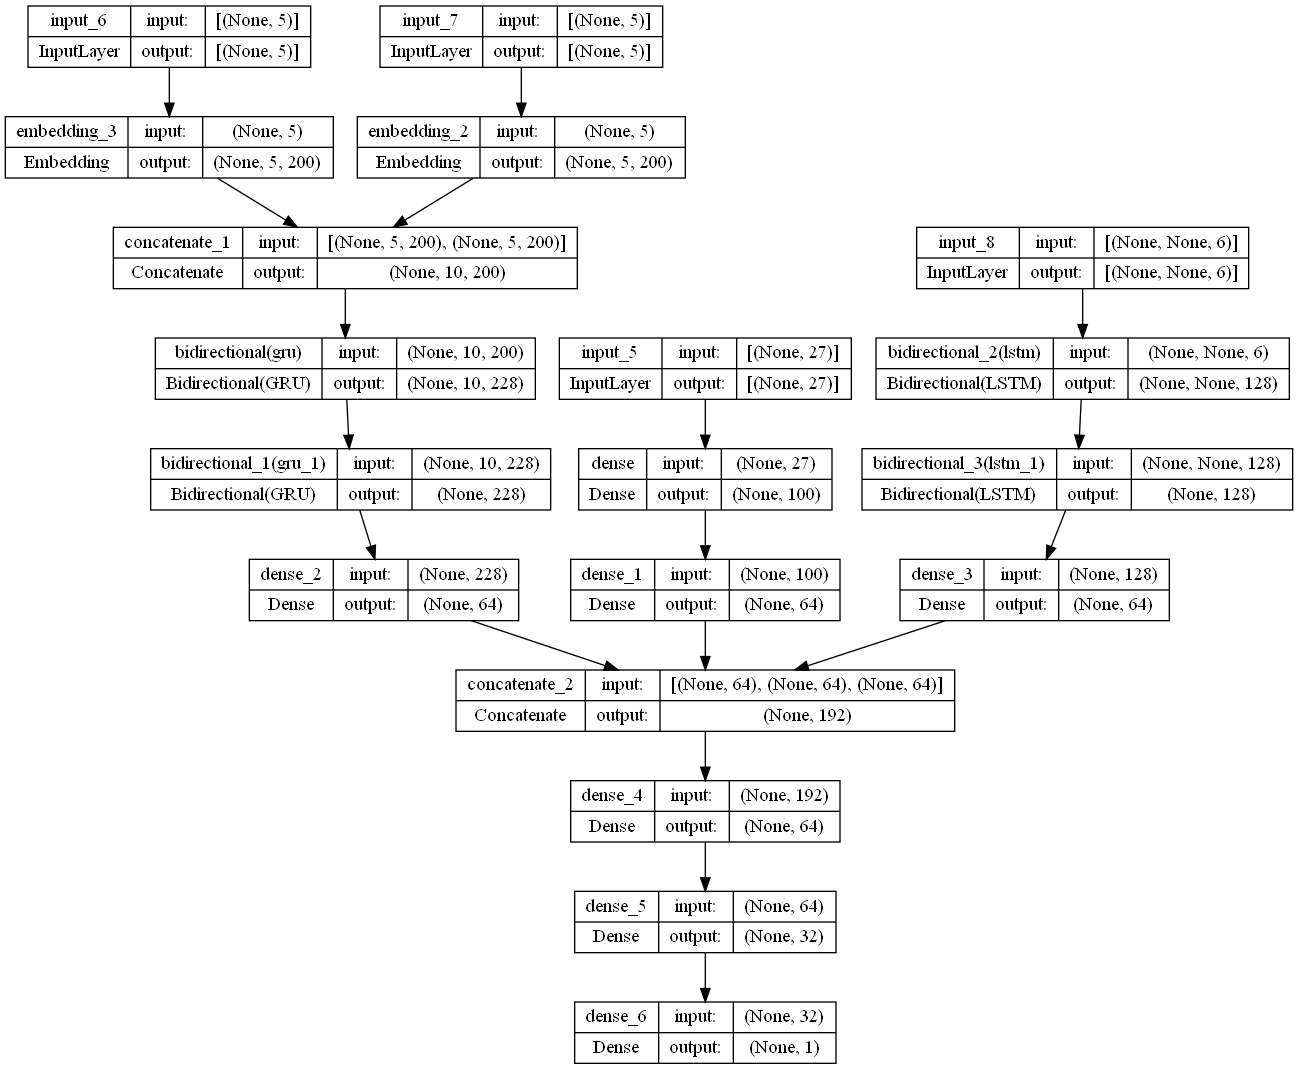

<Figure size 2000x2000 with 0 Axes>

In [167]:
from keras.utils.vis_utils import plot_model
# set size of the figure
plt.figure(figsize=(20,20))
plot_model(model, show_shapes=True, show_layer_names=True, dpi=96)

In [168]:
# load the model
load_model = keras.models.load_model('model/mortality_NN.h5')

In [169]:
y_test_pred = load_model.predict(x=[test_x,test_his_vec,test_chef_vec, test_x_vital])

1058/1058 [==============================] - 12s 9ms/step


In [174]:
weights = {0:1-(sum(train_y)/len(train_y)),1:sum(train_y)/len(train_y)}
weights

{0: 0.9987587185246483, 1: 0.0012412814753516965}

In [175]:
y_pred_test_class = np.where(y_test_pred> weights[1], 1, 0)

In [176]:
print(classification_report(test_y, y_pred_test_class.round()))
# balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print('balanced accuracy: ', balanced_accuracy_score(test_y, y_pred_test_class.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33798
           1       0.67      0.11      0.19        37

    accuracy                           1.00     33835
   macro avg       0.83      0.55      0.59     33835
weighted avg       1.00      1.00      1.00     33835

balanced accuracy:  0.5540244665044949


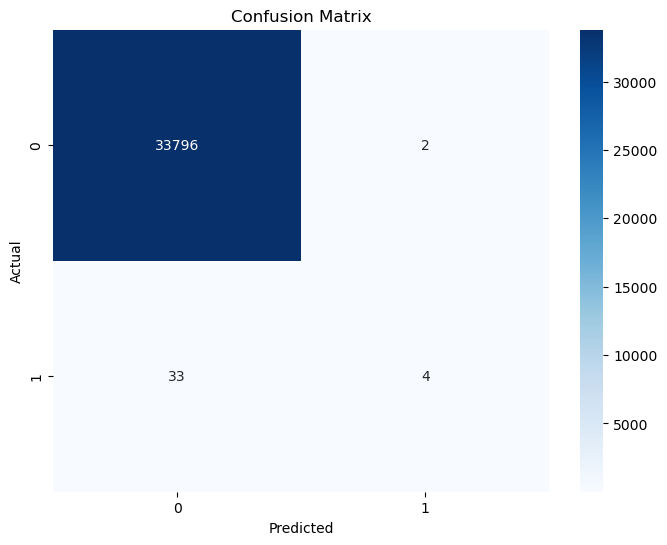

In [177]:
# plot the confusion matrix
cm = confusion_matrix(test_y, y_pred_test_class.round())

# set figure size
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()